In [45]:
!pip install -q scanpy[leiden] harmonypy symphonypy 2>/dev/null

In [ ]:
!pip install sccoda

In [47]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import warnings
import scanpy as sc
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [48]:
np.random.seed(42)
n_donors = 20
cell_types = ['CD4_Naive', 'CD8_Naive', 'Monocyte', 'B_cell', 'NK']

group1_data = []
for i in range(n_donors//2):
    counts = [
        np.random.randint(800, 1200),
        np.random.randint(300, 600),
        np.random.randint(100, 300),
        np.random.randint(200, 400),
        np.random.randint(100, 300),
    ]
    group1_data.append(counts)

group2_data = []
for i in range(n_donors//2):
    counts = [
        np.random.randint(300, 600),
        np.random.randint(300, 600),
        np.random.randint(800, 1200),
        np.random.randint(200, 400),
        np.random.randint(100, 300),
    ]
    group2_data.append(counts)

test_counts = pd.DataFrame(
    group1_data + group2_data,
    columns=cell_types
)
test_counts['donor_id'] = [f'Test_A_{i}' for i in range(n_donors//2)] + \
                          [f'Test_B_{i}' for i in range(n_donors//2)]
test_counts['condition'] = ['Group1'] * (n_donors//2) + ['Group2'] * (n_donors//2)

test_counts.to_csv('TEST_dataset_with_differences.csv', index=False)

cell_cols = [c for c in test_counts.columns if c not in ['donor_id', 'condition']]
test_props = test_counts[cell_cols].div(test_counts[cell_cols].sum(axis=1), axis=0)
test_props['condition'] = test_counts['condition']
print(test_props.groupby('condition').mean().round(3))

           CD4_Naive  CD8_Naive  Monocyte  B_cell     NK
condition                                               
Group1         0.474      0.206     0.089   0.134  0.097
Group2         0.175      0.190     0.431   0.119  0.085


In [49]:
df = pd.read_csv('TEST_dataset_with_differences.csv')

cell_type_cols = [col for col in df.columns if col not in ['donor_id', 'condition']]
group1 = df[df['condition'] == 'Group1']
group2 = df[df['condition'] == 'Group2']

results = []

In [50]:
for cell_type in cell_type_cols:
    data_group1 = group1[cell_type].values
    data_group2 = group2[cell_type].values

    t_stat, p_val = ttest_ind(data_group1, data_group2, equal_var=False, nan_policy='omit')
    mean_diff = data_group1.mean() - data_group2.mean()

    results.append({
        'cell_type': cell_type,
        'mean_Group1': data_group1.mean(),
        'mean_Group2': data_group2.mean(),
        'mean_diff': mean_diff,
        't_statistic': t_stat,
        'p_value': p_val
    })

In [51]:
ttest_results = pd.DataFrame(results)

ttest_results['p_value_adj'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]
ttest_results['significant'] = ttest_results['p_value_adj'] < 0.05

ttest_results = ttest_results.sort_values('p_value')

print(ttest_results[['cell_type', 'mean_Group1', 'mean_Group2',
                        'mean_diff', 'p_value', 'p_value_adj', 'significant']].to_string())

print(f"Значимых типов клеток (FDR < 0.05): {ttest_results['significant'].sum()} из {len(ttest_results)}")

   cell_type  mean_Group1  mean_Group2  mean_diff       p_value   p_value_adj  significant
2   Monocyte        189.2       1036.9     -847.7  4.310671e-11  2.155336e-10         True
0  CD4_Naive       1008.7        421.8      586.9  9.962924e-10  2.490731e-09         True
1  CD8_Naive        439.9        456.1      -16.2  6.918957e-01  9.555267e-01        False
4         NK        208.6        205.1        3.5  9.059691e-01  9.555267e-01        False
3     B_cell        284.9        286.4       -1.5  9.555267e-01  9.555267e-01        False
Значимых типов клеток (FDR < 0.05): 2 из 5


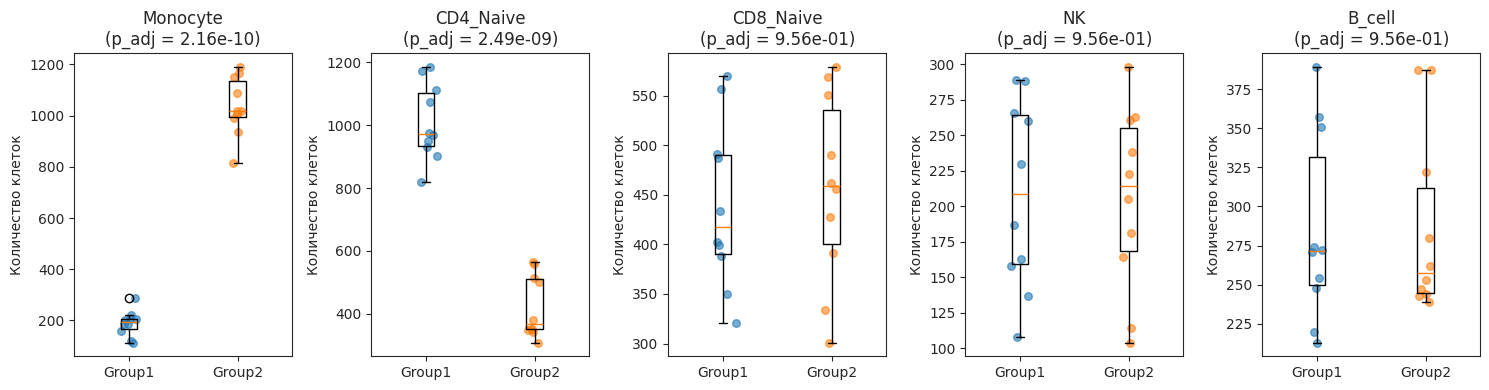

In [52]:
top_n = min(5, len(ttest_results))
fig, axes = plt.subplots(1, top_n, figsize=(3*top_n, 4))

if top_n == 1:
    axes = [axes]

for idx in range(top_n):
    cell_type = ttest_results.iloc[idx]['cell_type']
    ax = axes[idx]

    data_to_plot = [group1[cell_type].values, group2[cell_type].values]
    ax.boxplot(data_to_plot, labels=['Group1', 'Group2'])
    ax.set_title(f"{cell_type}\n(p_adj = {ttest_results.iloc[idx]['p_value_adj']:.2e})")
    ax.set_ylabel('Количество клеток')

    for i, group_data in enumerate(data_to_plot, 1):
        x = np.random.normal(i, 0.04, size=len(group_data))
        ax.scatter(x, group_data, alpha=0.6, s=30)

plt.tight_layout()
plt.show()

In [53]:
sccoda_df = df[cell_type_cols + ['condition']].copy()
sccoda_df = sccoda_df.rename(columns={'condition': 'condition'})

adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["condition"]
)

In [54]:
model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="condition",
    reference_cell_type="automatic"
)

results = model.sample_hmc()

Automatic reference selection! Reference cell type set to B_cell


100%|██████████| 20000/20000 [03:50<00:00, 86.61it/s] 


MCMC sampling finished. (291.087 sec)
Acceptance rate: 64.2%


In [55]:
# Сохраняем результаты
results.save("sccoda_test_results")
summary = results.summary()
print(summary)

# Извлекаем значимые эффекты (вероятность > 0.95)
credible_effects = results.credible_effects()
print(f"\nЗначимо измененные типы клеток (вероятность > 0.95): {credible_effects.sum()}")

Compositional Analysis summary:

Data: 20 samples, 5 cell types
Reference index: 3
Formula: condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
CD4_Naive            4.141      1073.436566
CD8_Naive            3.319       471.830837
Monocyte             2.481       204.102134
B_cell               2.878       303.572519
NK                   2.537       215.857944


Effects:
                               Final Parameter  Expected Sample  \
Covariate           Cell Type                                     
condition[T.Group2] CD4_Naive        -0.894085       396.461017   
                    CD8_Naive         0.000000       426.095053   
                    Monocyte          1.667991       977.163207   
                    B_cell            0.000000       274.146449   
                    NK                0.000000       194.934275   

                               log2-fold change  
Covariate           Cell Type                 

<Axes: xlabel='Cell type', ylabel='Proportion'>

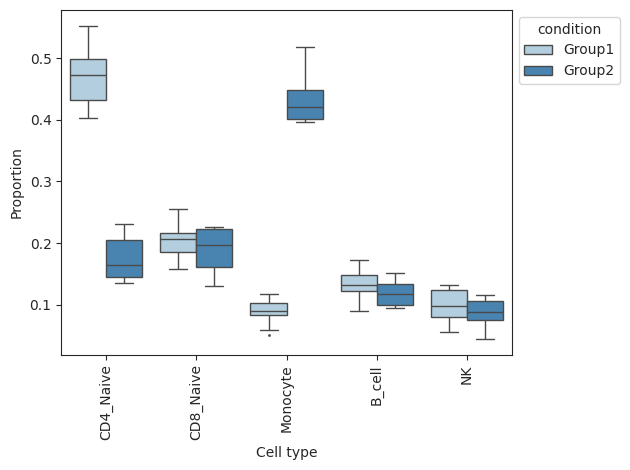

In [56]:
viz.boxplots(adata_sccoda, feature_name="condition")

In [57]:
np.random.seed(8)

n_donors_per_group = 15
cell_types = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil', 'Basophil']

data_abs = []

for i in range(n_donors_per_group):
    abs_counts = [
        np.random.randint(800, 1200),
        np.random.randint(1500, 2000),
        np.random.randint(200, 400),
        np.random.randint(50, 150),
        np.random.randint(20, 50)
    ]
    data_abs.append(abs_counts + ['Group_A'])

for i in range(n_donors_per_group):
    abs_counts = [
        np.random.randint(4000, 6000),
        np.random.randint(1500, 2000),
        np.random.randint(200, 400),
        np.random.randint(50, 150),
        np.random.randint(20, 50)
    ]
    data_abs.append(abs_counts + ['Group_B'])

columns_abs = cell_types + ['condition']
df_absolute = pd.DataFrame(data_abs, columns=columns_abs)
df_absolute['donor_id'] = [f'Donor_A_{i}' for i in range(n_donors_per_group)] + \
                           [f'Donor_B_{i}' for i in range(n_donors_per_group)]

df_proportions = df_absolute[cell_types].copy()
df_proportions = df_proportions.div(df_proportions.sum(axis=1), axis=0) # Нормируем на 100%
df_proportions['condition'] = df_absolute['condition']
df_proportions['donor_id'] = df_absolute['donor_id']

abs_summary = df_absolute.groupby('condition')[cell_types].mean().astype(int)
print(abs_summary)

prop_summary = df_proportions.groupby('condition')[cell_types].mean().round(4)
print(prop_summary)

df_absolute.to_csv('trap_dataset_ABSOLUTE.csv', index=False)
df_proportions.to_csv('trap_dataset_PROPORTIONS.csv', index=False)

           Neutrophil  Lymphocyte  Monocyte  Eosinophil  Basophil
condition                                                        
Group_A           999        1731       300          93        34
Group_B          4889        1770       313          97        34
           Neutrophil  Lymphocyte  Monocyte  Eosinophil  Basophil
condition                                                        
Group_A        0.3160      0.5476    0.0958      0.0298    0.0108
Group_B        0.6868      0.2504    0.0444      0.0136    0.0048


In [58]:
ttest_results = []
group_a_prop = df_proportions[df_proportions['condition']=='Group_A']
group_b_prop = df_proportions[df_proportions['condition']=='Group_B']

for cell_type in cell_types:
    t_stat, p_val = ttest_ind(group_a_prop[cell_type], group_b_prop[cell_type], equal_var=False)
    mean_diff = group_a_prop[cell_type].mean() - group_b_prop[cell_type].mean()
    ttest_results.append({
        'cell_type': cell_type,
        'mean_diff_prop': mean_diff,
        't_statistic': t_stat,
        'p_value': p_val
    })

ttest_results = pd.DataFrame(ttest_results)
ttest_results['p_value_adj'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]
ttest_results['significant'] = ttest_results['p_value_adj'] < 0.05
ttest_results = ttest_results.sort_values('p_value')

print(ttest_results.to_string())

for _, row in ttest_results[ttest_results['significant']].iterrows():
    direction = "выше в Group_A" if row['mean_diff_prop'] > 0 else "ниже в Group_A"
    print(f"  - {row['cell_type']}: {direction} (p_adj={row['p_value_adj']:.2e})")

    cell_type  mean_diff_prop  t_statistic       p_value   p_value_adj  significant
0  Neutrophil       -0.370761   -32.167497  3.342497e-23  1.671249e-22         True
1  Lymphocyte        0.297186    26.743495  3.652418e-21  9.131044e-21         True
2    Monocyte        0.051391     9.093028  1.906882e-08  3.178137e-08         True
4    Basophil        0.006001     6.998066  9.106864e-07  1.107769e-06         True
3  Eosinophil        0.016183     6.910268  1.107769e-06  1.107769e-06         True
  - Neutrophil: ниже в Group_A (p_adj=1.67e-22)
  - Lymphocyte: выше в Group_A (p_adj=9.13e-21)
  - Monocyte: выше в Group_A (p_adj=3.18e-08)
  - Basophil: выше в Group_A (p_adj=1.11e-06)
  - Eosinophil: выше в Group_A (p_adj=1.11e-06)


In [59]:
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod

df_for_sccoda = df_absolute[cell_types + ['condition']].copy()
adata_sccoda = dat.from_pandas(df_for_sccoda, covariate_columns=["condition"])

model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="condition",
    reference_cell_type="automatic"
)

results = model.sample_hmc()

summary = results.summary()
print(summary)

credible_effects = results.credible_effects()
print(credible_effects)

Automatic reference selection! Reference cell type set to Basophil


100%|██████████| 20000/20000 [03:46<00:00, 88.49it/s]


MCMC sampling finished. (283.745 sec)
Acceptance rate: 64.6%
Compositional Analysis summary:

Data: 30 samples, 5 cell types
Reference index: 4
Formula: condition

Intercepts:
            Final Parameter  Expected Sample
Cell Type                                   
Neutrophil            4.506      1624.322662
Lymphocyte            5.050      2798.520558
Monocyte              3.315       493.659587
Eosinophil            2.159       155.375720
Basophil              1.220        60.754806


Effects:
                                 Final Parameter  Expected Sample  \
Covariate            Cell Type                                      
condition[T.Group_B] Neutrophil         1.552862      3522.460477   
                     Lymphocyte         0.000000      1284.407872   
                     Monocyte           0.000000       226.569806   
                     Eosinophil         0.000000        71.311178   
                     Basophil           0.000000        27.884001   

              

<Axes: xlabel='Cell type', ylabel='Proportion'>

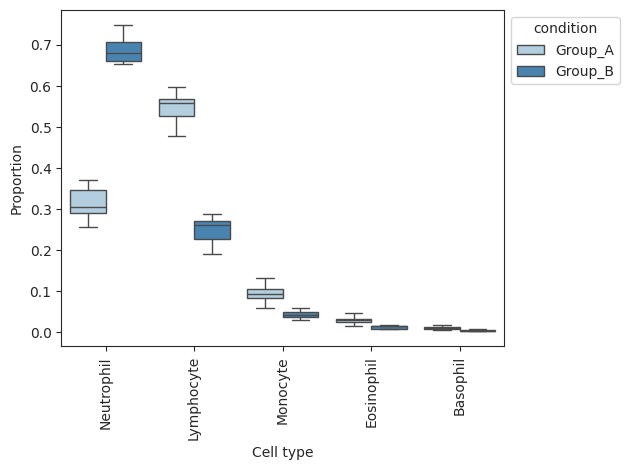

In [60]:
viz.boxplots(adata_sccoda, feature_name="condition")

In [61]:
np.random.seed(66)
n_normal_samples = 19
n_outliers = 3
cell_types = ['CD4_Naive', 'CD8_Naive', 'Monocyte', 'B_cell', 'NK', 'Treg']


base_counts = {
    'CD4_Naive': (800, 1200),
    'CD8_Naive': (300, 600),
    'Monocyte': (200, 400),
    'B_cell': (200, 400),
    'NK': (100, 300),
    'Treg': (50, 150)
}

group_a_data = []
for i in range(n_normal_samples):
    counts = [np.random.randint(low, high) for low, high in base_counts.values()]
    group_a_data.append(counts + ['Group_A'])

group_b_data = []

for i in range(n_normal_samples):
    counts = [np.random.randint(low, high) for low, high in base_counts.values()]
    counts[2] = int(counts[2] * 1.5)  # Monocyte
    group_b_data.append(counts + ['Group_B'])

outlier1 = [np.random.randint(low, high) for low, high in base_counts.values()]
outlier1[2] = outlier1[2] * 20  # Monocyte в 20 раз выше нормы
group_b_data.append(outlier1 + ['Group_B'])

outlier2 = [int(np.random.randint(low, high) / 10) for low, high in base_counts.values()]  # В 10 раз меньше
group_b_data.append(outlier2 + ['Group_B'])

outlier3 = [np.random.randint(low, high) for low, high in base_counts.values()]
outlier3[3] = 0  # Нет B_cell вообще
group_b_data.append(outlier3 + ['Group_B'])

columns = cell_types + ['condition']
all_data = group_a_data + group_b_data

df_with_outliers = pd.DataFrame(all_data, columns=columns)
df_with_outliers['donor_id'] = [f'A_{i:02d}' for i in range(n_normal_samples)] + \
                                [f'B_{i:02d}' for i in range(n_normal_samples)] + \
                                ['B_out1', 'B_out2', 'B_out3']


df_with_outliers.to_csv('robustness_test_with_outliers.csv', index=False)

normal_samples_mask = ~df_with_outliers['donor_id'].str.contains('out')
df_without_outliers = df_with_outliers[normal_samples_mask].copy()
df_without_outliers.to_csv('robustness_test_without_outliers.csv', index=False)

outliers_df = df_with_outliers[df_with_outliers['donor_id'].str.contains('out')]
for _, row in outliers_df.iterrows():
    total_cells = row[cell_types].sum()
    print(f"\n{row['donor_id']} ({row['condition']}):")
    print(f"  Всего клеток: {total_cells}")
    for ct in cell_types:
        if row[ct] > base_counts[ct][1] * 5:  # В 5 раз выше максимума
            print(f"  ! {ct}: {row[ct]} (экстремально высокое)")
        elif row[ct] < base_counts[ct][0] * 0.2:  # В 5 раз ниже минимума
            print(f"  ! {ct}: {row[ct]} (аномально низкое)")


B_out1 (Group_B):
  Всего клеток: 8884
  ! Monocyte: 7140 (экстремально высокое)

B_out2 (Group_B):
  Всего клеток: 246
  ! CD4_Naive: 92 (аномально низкое)
  ! CD8_Naive: 51 (аномально низкое)
  ! Monocyte: 35 (аномально низкое)
  ! B_cell: 37 (аномально низкое)
  ! NK: 19 (аномально низкое)

B_out3 (Group_B):
  Всего клеток: 2126
  ! B_cell: 0 (аномально низкое)


In [62]:
def run_ttest_analysis(df, title):

    cell_type_cols = [col for col in df.columns if col not in ['donor_id', 'condition']]
    group_a = df[df['condition'] == 'Group_A']
    group_b = df[df['condition'] == 'Group_B']

    results = []
    for cell_type in cell_type_cols:
        t_stat, p_val = ttest_ind(group_a[cell_type], group_b[cell_type], equal_var=False)
        mean_diff = group_a[cell_type].mean() - group_b[cell_type].mean()
        results.append({
            'cell_type': cell_type,
            'mean_diff': mean_diff,
            't_statistic': t_stat,
            'p_value': p_val
        })

    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        results_df['p_value_adj'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
        results_df['significant'] = results_df['p_value_adj'] < 0.05

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(range(len(results_df)), -np.log10(results_df['p_value_adj']))
    axes[0].axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5, label='FDR=0.05')
    axes[0].set_xticks(range(len(results_df)))
    axes[0].set_xticklabels(results_df['cell_type'], rotation=45, ha='right')
    axes[0].set_ylabel('-log10(adj. p-value)')
    axes[0].set_title(f'{title}\nЗначимость различий')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    x = np.arange(len(cell_type_cols))
    width = 0.35
    means_a = [group_a[ct].mean() for ct in cell_type_cols]
    means_b = [group_b[ct].mean() for ct in cell_type_cols]

    axes[1].bar(x - width/2, means_a, width, label='Group_A', alpha=0.7)
    axes[1].bar(x + width/2, means_b, width, label='Group_B', alpha=0.7)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cell_type_cols, rotation=45, ha='right')
    axes[1].set_ylabel('Среднее количество клеток')
    axes[1].set_title('Средние значения по группам')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

In [63]:
def run_sccoda_analysis(df, title):
    """Запуск scCODA анализа"""
    try:
        from sccoda.util import cell_composition_data as dat
        from sccoda.util import comp_ana as mod

        cell_type_cols = [col for col in df.columns if col not in ['donor_id', 'condition']]
        sccoda_df = df[cell_type_cols + ['condition']].copy()

        adata_sccoda = dat.from_pandas(sccoda_df, covariate_columns=["condition"])
        viz.boxplots(adata_sccoda, feature_name="condition")
        model = mod.CompositionalAnalysis(
            data=adata_sccoda,
            formula="condition",
            reference_cell_type="automatic"
        )

        try:
            results = model.sample_hmc()
        except AttributeError:
            results = model.sample(num_draws=20000)

        credible_effects = results.credible_effects()

        effect_df = results.effect_df
        if len(effect_df) > 0:
            plt.figure(figsize=(10, 6))
            significant = effect_df[effect_df["Final Parameter"] == "effect"]

            if len(significant) > 0:
                colors = ['red' if x else 'gray' for x in credible_effects]
                plt.scatter(range(len(effect_df)), effect_df["log2-fold change"],
                           c=colors, alpha=0.6, s=100)
                plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Значимое изменение')
                plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5)

                # Подписи для значимых эффектов
                for idx, row in significant.iterrows():
                    plt.annotate(row["Cell Type"],
                                xy=(idx, row["log2-fold change"]),
                                xytext=(0, 10), textcoords='offset points',
                                ha='center', fontsize=9)

                plt.xlabel('Типы клеток')
                plt.ylabel('log2 fold change')
                plt.title(f'{title}\nscCODA: изменения в составе клеток')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

        return credible_effects, results.summary()

    except Exception as e:
        print(f"Ошибка в scCODA: {e}")
        return None, None

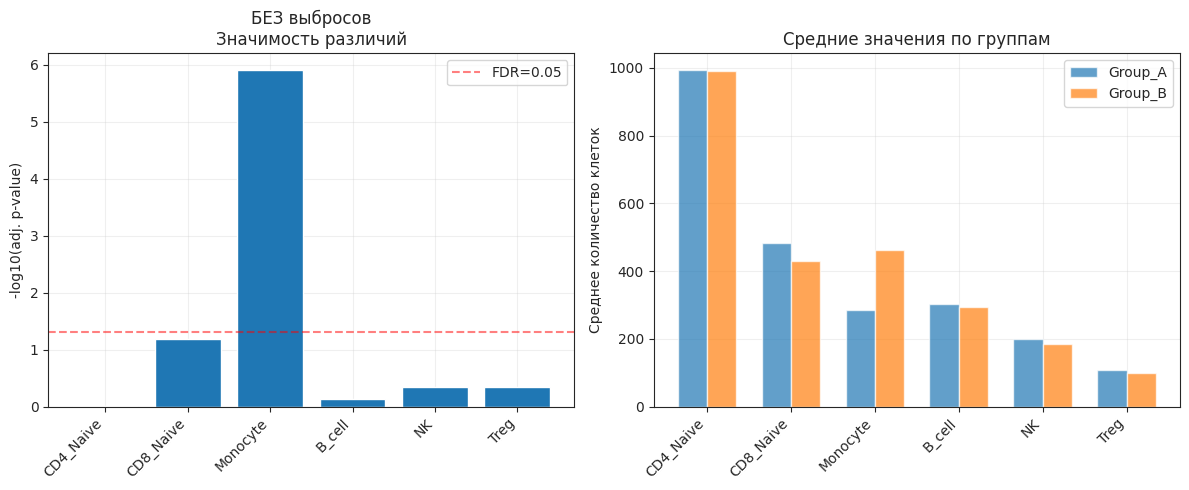

Automatic reference selection! Reference cell type set to Treg


100%|██████████| 20000/20000 [03:49<00:00, 87.13it/s]


MCMC sampling finished. (294.758 sec)
Acceptance rate: 69.8%
Compositional Analysis summary:

Data: 38 samples, 6 cell types
Reference index: 5
Formula: condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
CD4_Naive            4.589      1024.048579
CD8_Naive            3.833       480.832629
Monocyte             3.333       291.639732
B_cell               3.393       309.673726
NK                   2.968       202.455325
Treg                 2.346       108.692114


Effects:
                                Final Parameter  Expected Sample  \
Covariate            Cell Type                                     
condition[T.Group_B] CD4_Naive         0.000000       948.234307   
                     CD8_Naive         0.000000       445.234732   
                     Monocyte          0.508452       449.013690   
                     B_cell            0.000000       286.747384   
                     NK                0.000000      

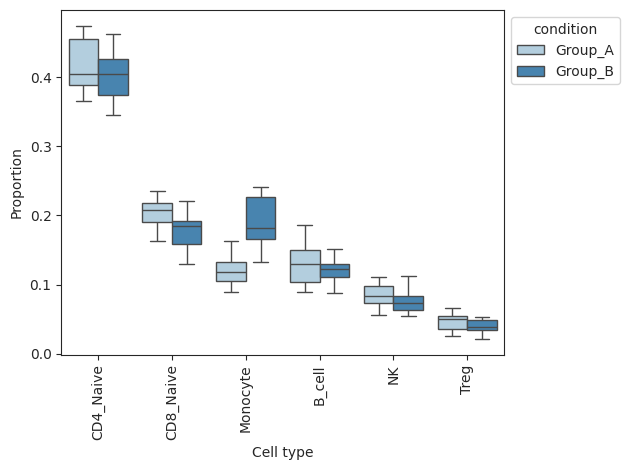

<Figure size 1000x600 with 0 Axes>

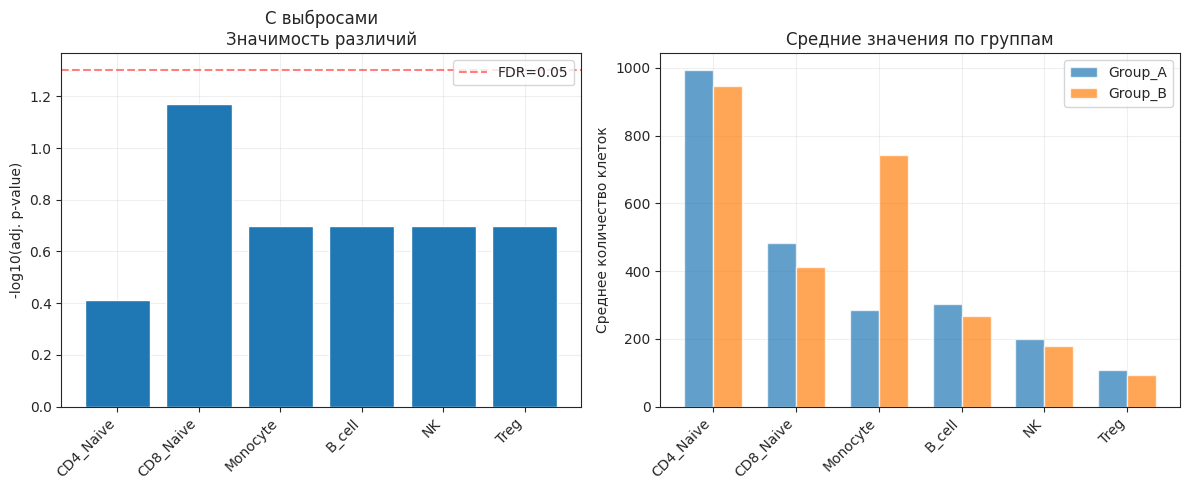

Automatic reference selection! Reference cell type set to Treg
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:02<00:00, 82.59it/s]


MCMC sampling finished. (302.772 sec)
Acceptance rate: 57.7%
Compositional Analysis summary:

Data: 41 samples, 6 cell types
Reference index: 5
Formula: condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
CD4_Naive            3.587      1055.158193
CD8_Naive            2.873       516.691498
Monocyte             2.365       310.892123
B_cell               2.409       324.876783
NK                   2.007       217.336312
Treg                 1.126        90.057286


Effects:
                                Final Parameter  Expected Sample  \
Covariate            Cell Type                                     
condition[T.Group_B] CD4_Naive        -0.559518       971.092530   
                     CD8_Naive        -0.640235       438.650998   
                     Monocyte          0.000000       500.666148   
                     B_cell           -0.701435       259.434623   
                     NK               -0.558932      

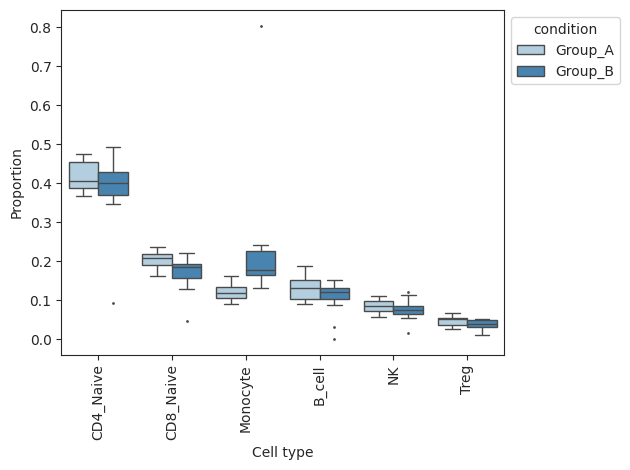

<Figure size 1000x600 with 0 Axes>

In [64]:
df_normal = pd.read_csv('robustness_test_without_outliers.csv')
ttest_normal = run_ttest_analysis(df_normal, "БЕЗ выбросов")
sccoda_normal, summary_normal = run_sccoda_analysis(df_normal, "БЕЗ выбросов")

df_outliers = pd.read_csv('robustness_test_with_outliers.csv')
ttest_outliers = run_ttest_analysis(df_outliers, "С выбросами")
sccoda_outliers, summary_outliers = run_sccoda_analysis(df_outliers, "С выбросами")

In [65]:
comparison = []
for cell_type in cell_types:
    # T-test результаты
    ttest_norm = ttest_normal[ttest_normal['cell_type'] == cell_type]
    ttest_out = ttest_outliers[ttest_outliers['cell_type'] == cell_type]

    ttest_norm_sig = ttest_norm['significant'].values[0] if len(ttest_norm) > 0 else False
    ttest_out_sig = ttest_out['significant'].values[0] if len(ttest_out) > 0 else False
    ttest_robust = ttest_norm_sig == ttest_out_sig

    sccoda_norm_sig = False
    sccoda_out_sig = False

    if isinstance(sccoda_normal, pd.Series):
        sccoda_norm_sig = cell_type in sccoda_normal.index and sccoda_normal[cell_type]
    elif isinstance(sccoda_normal, dict):
        sccoda_norm_sig = sccoda_normal.get(cell_type, False)

    if isinstance(sccoda_outliers, pd.Series):
        sccoda_out_sig = cell_type in sccoda_outliers.index and sccoda_outliers[cell_type]
    elif isinstance(sccoda_outliers, dict):
        sccoda_out_sig = sccoda_outliers.get(cell_type, False)

    sccoda_robust = sccoda_norm_sig == sccoda_out_sig

    # Также посмотрим изменение p-value в t-test
    pval_norm = ttest_norm['p_value_adj'].values[0] if len(ttest_norm) > 0 else 1.0
    pval_out = ttest_out['p_value_adj'].values[0] if len(ttest_out) > 0 else 1.0
    pval_change = abs(pval_out - pval_norm) / pval_norm if pval_norm > 0 else 0


In [67]:
# Анализируем каждый выброс отдельно
outlier_samples = df_with_outliers[df_with_outliers['donor_id'].str.contains('out')]
for _, outlier in outlier_samples.iterrows():
    print(f"\nАнализ выброса {outlier['donor_id']}:")
    total_cells = outlier[cell_types].sum()
    print(f"  Всего клеток: {total_cells}")

    # Находим аномальные значения
    for ct in cell_types:
        value = outlier[ct]
        normal_range = base_counts[ct]
        if value > normal_range[1] * 3:  # В 3 раза выше максимума
            print(f"  ! {ct}: {value} (в {value/normal_range[1]:.1f} раз выше нормы)")
        elif value == 0 and normal_range[0] > 0:
            print(f"  ! {ct}: {value} (полное отсутствие)")
        elif value < normal_range[0] * 0.3:  # В 3 раза ниже минимума
            print(f"  ! {ct}: {value} (в {normal_range[0]/value:.1f} раз ниже нормы)")


Анализ выброса B_out1:
  Всего клеток: 8884
  ! Monocyte: 7140 (в 17.9 раз выше нормы)

Анализ выброса B_out2:
  Всего клеток: 246
  ! CD4_Naive: 92 (в 8.7 раз ниже нормы)
  ! CD8_Naive: 51 (в 5.9 раз ниже нормы)
  ! Monocyte: 35 (в 5.7 раз ниже нормы)
  ! B_cell: 37 (в 5.4 раз ниже нормы)
  ! NK: 19 (в 5.3 раз ниже нормы)
  ! Treg: 12 (в 4.2 раз ниже нормы)

Анализ выброса B_out3:
  Всего клеток: 2126
  ! B_cell: 0 (полное отсутствие)


In [68]:
np.random.seed(42)
n_donors = 25
cell_types = ['CD4_Naive', 'CD8_Naive', 'Monocyte', 'B_cell', 'NK', 'Treg', 'pDC']

# Базовые параметры (средние количества для здоровых доноров)
base_params = {
    'CD4_Naive': {'mean': 1500, 'std': 200},
    'CD8_Naive': {'mean': 800, 'std': 150},
    'Monocyte': {'mean': 400, 'std': 80},
    'B_cell': {'mean': 300, 'std': 70},
    'NK': {'mean': 200, 'std': 50},
    'Treg': {'mean': 20, 'std': 8},
    'pDC': {'mean': 15, 'std': 6}
}

In [69]:
def generate_sample(group_type):
    """Генерация образца с учётом группы"""
    sample = {}

    for cell_type in cell_types:
        mean = base_params[cell_type]['mean']
        std = base_params[cell_type]['std']

        if group_type == 'Disease':
            if cell_type == 'Treg':
                count = np.random.normal(mean * 4, std * 2)
            elif cell_type == 'pDC':
                count = np.random.normal(mean * 0.6, std)
            elif cell_type == 'CD4_Naive':
                count = np.random.normal(mean * 0.9, std)
            else:
                count = np.random.normal(mean, std)
        else:
            count = np.random.normal(mean, std)

        sample[cell_type] = max(int(count), 0)

    sample['condition'] = group_type
    return sample

In [70]:
data = []
for i in range(n_donors):
    data.append(generate_sample('Control'))
for i in range(n_donors):
    data.append(generate_sample('Disease'))

df_rare = pd.DataFrame(data)
df_rare['donor_id'] = [f'C_{i:03d}' for i in range(n_donors)] + \
                      [f'D_{i:03d}' for i in range(n_donors)]

df_rare['total_cells'] = df_rare[cell_types].sum(axis=1)

df_rare.to_csv('rare_population_dataset.csv', index=False)

props = df_rare[cell_types].div(df_rare[cell_types].sum(axis=1), axis=0) * 100
props['condition'] = df_rare['condition']

summary = props.groupby('condition').mean()

rare_cells = ['Treg', 'pDC']
for ct in rare_cells:
    ctrl_abs = df_rare[df_rare['condition']=='Control'][ct].mean()
    dis_abs = df_rare[df_rare['condition']=='Disease'][ct].mean()
    fold_abs = dis_abs / ctrl_abs

    from scipy.stats import ttest_ind
    t_stat, p_val = ttest_ind(
        df_rare[df_rare['condition']=='Control'][ct],
        df_rare[df_rare['condition']=='Disease'][ct],
        equal_var=False
    )

    sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""

    print(f"  {ct}: {ctrl_abs:.1f} → {dis_abs:.1f} клеток ({fold_abs:.1f}x){sig_star} p={p_val:.2e}")

  Treg: 20.1 → 79.9 клеток (4.0x)*** p=2.70e-19
  pDC: 15.2 → 9.0 клеток (0.6x)** p=1.67e-03


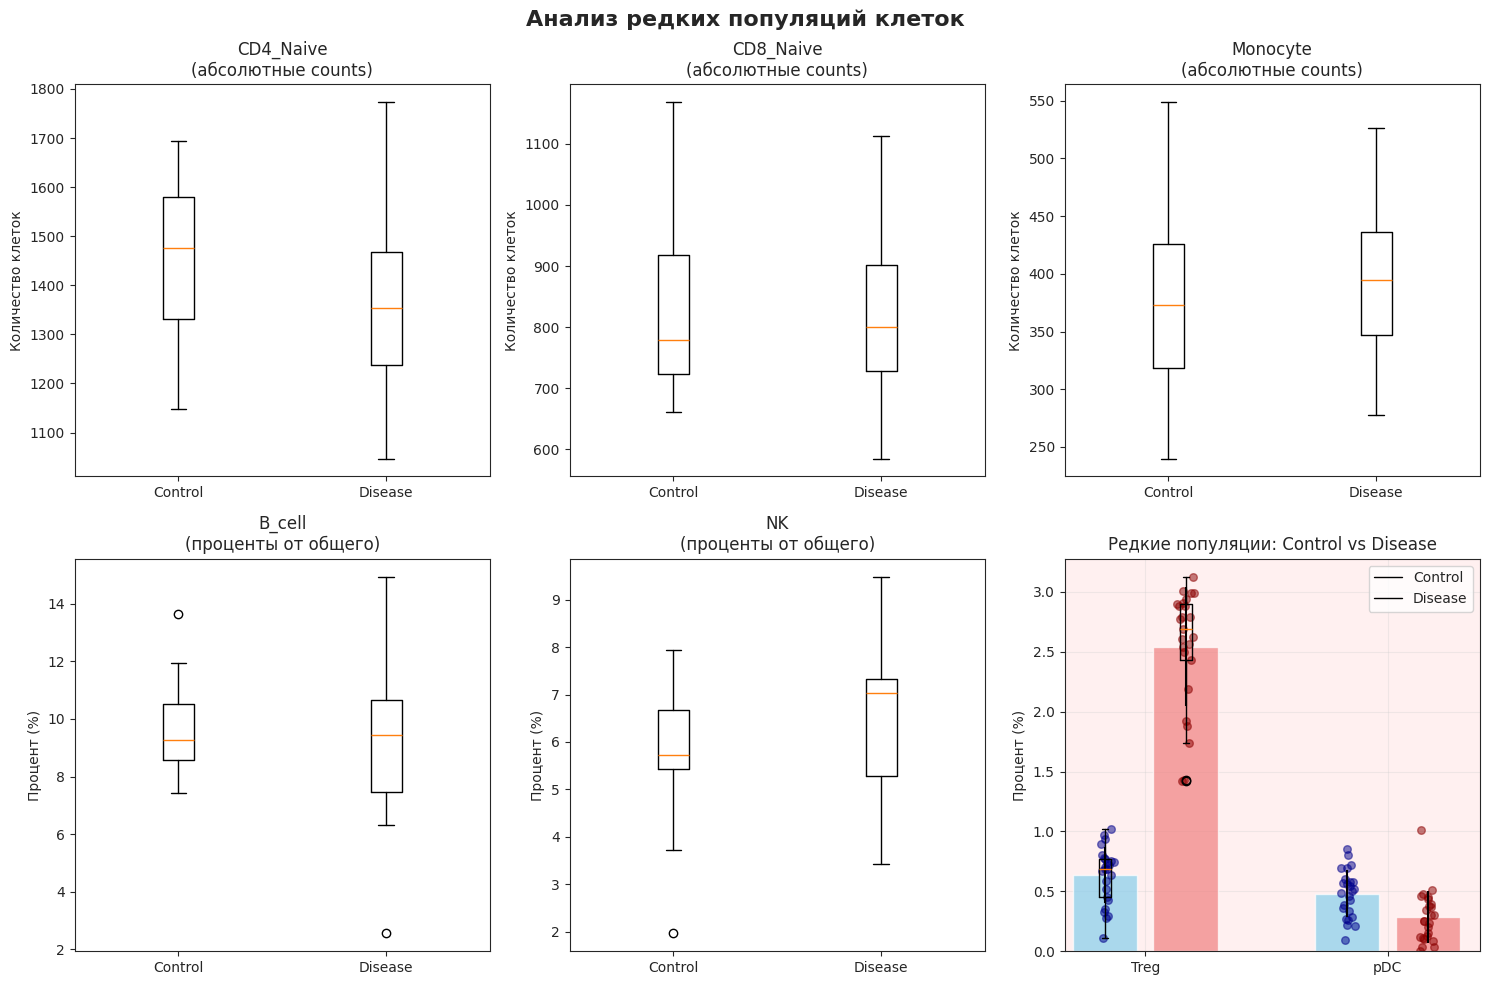

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, cell_type in enumerate(cell_types[:3]):
    ax = axes[0, idx]
    data_to_plot = [df_rare[df_rare['condition']=='Control'][cell_type],
                    df_rare[df_rare['condition']=='Disease'][cell_type]]
    ax.boxplot(data_to_plot, labels=['Control', 'Disease'])
    ax.set_title(f'{cell_type}\n(абсолютные counts)')
    ax.set_ylabel('Количество клеток')
    if cell_type in ['Treg', 'pDC']:
        ax.set_facecolor('#fff0f0')  # Подсветка для редких

for idx, cell_type in enumerate(cell_types[3:6]):
    ax = axes[1, idx-3]
    prop_data = [props[props['condition']=='Control'][cell_type],
                 props[props['condition']=='Disease'][cell_type]]
    ax.boxplot(prop_data, labels=['Control', 'Disease'])
    ax.set_title(f'{cell_type}\n(проценты от общего)')
    ax.set_ylabel('Процент (%)')
    if cell_type in ['Treg', 'pDC']:
        ax.set_facecolor('#fff0f0')

ax_rare = axes[1, 2]
x_pos = [1, 2, 4, 5]
conditions = ['Control', 'Disease', 'Control', 'Disease']
cell_labels = ['Treg', 'Treg', 'pDC', 'pDC']

for i, (cond, cell_lbl) in enumerate(zip(conditions, cell_labels)):
    subset = props[(props['condition']==cond) & (props.index.isin(df_rare.index))]
    mean_val = subset[cell_lbl].mean()
    std_val = subset[cell_lbl].std()

    ax_rare.bar(x_pos[i], mean_val, yerr=std_val,
                alpha=0.7, color='skyblue' if cond=='Control' else 'lightcoral')

    donor_vals = subset[cell_lbl].values
    jitter = np.random.normal(0, 0.05, size=len(donor_vals))
    ax_rare.scatter([x_pos[i] + j for j in jitter], donor_vals,
                   alpha=0.5, s=30, color='darkblue' if cond=='Control' else 'darkred')

ax_rare.set_xticks([1.5, 4.5])
ax_rare.set_xticklabels(['Treg', 'pDC'])
ax_rare.set_ylabel('Процент (%)')
ax_rare.set_title('Редкие популяции: Control vs Disease')
ax_rare.legend(['Control', 'Disease'])
ax_rare.grid(True, alpha=0.3)

plt.suptitle('Анализ редких популяций клеток', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [72]:
from statsmodels.stats.power import TTestIndPower

for rare_cell in ['Treg', 'pDC']:
    ctrl_vals = df_rare[df_rare['condition']=='Control'][rare_cell]
    dis_vals = df_rare[df_rare['condition']=='Disease'][rare_cell]

    mean_diff = dis_vals.mean() - ctrl_vals.mean()
    pooled_std = np.sqrt((ctrl_vals.std()**2 + dis_vals.std()**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

    analysis = TTestIndPower()
    power = analysis.solve_power(
        effect_size=cohens_d,
        nobs1=n_donors,
        alpha=0.05,
        ratio=1.0
    )

    print(f"{rare_cell}:")
    print(f"Эффект Коэна: {cohens_d:.2f} ({'малый' if abs(cohens_d)<0.5 else 'средний' if abs(cohens_d)<0.8 else 'большой'})")
    print(f"Мощность t-test (n={n_donors}): {power:.1%}")
    print(f"Необходимый размер выборки для 80% мощности: {int(analysis.solve_power(effect_size=cohens_d, power=0.8, alpha=0.05))}")

props_df = df_rare.copy()
for ct in cell_types:
    props_df[f'{ct}_pct'] = props_df[ct] / props_df[cell_types].sum(axis=1) * 100
props_df.to_csv('rare_population_with_percentages.csv', index=False)

Treg:
Эффект Коэна: 5.12 (большой)
Мощность t-test (n=25): 100.0%
Необходимый размер выборки для 80% мощности: 2
pDC:
Эффект Коэна: -0.94 (большой)
Мощность t-test (n=25): 90.4%
Необходимый размер выборки для 80% мощности: 18


In [73]:
cell_type_cols = [col for col in df_rare.columns if col not in ['donor_id', 'condition', 'total_cells']]

ttest_results = []
for cell_type in cell_type_cols:
    ctrl_data = df_rare[df_rare['condition']=='Control'][cell_type]
    dis_data = df_rare[df_rare['condition']=='Disease'][cell_type]

    t_stat, p_val = ttest_ind(ctrl_data, dis_data, equal_var=False)
    mean_diff = dis_data.mean() - ctrl_data.mean()
    fold_change = dis_data.mean() / ctrl_data.mean() if ctrl_data.mean() > 0 else np.inf

    ttest_results.append({
        'cell_type': cell_type,
        'mean_ctrl': ctrl_data.mean(),
        'mean_dis': dis_data.mean(),
        'fold_change': fold_change,
        'mean_diff': mean_diff,
        't_statistic': t_stat,
        'p_value': p_val
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df['p_value_adj'] = multipletests(ttest_df['p_value'], method='fdr_bh')[1]
ttest_df['significant_ttest'] = ttest_df['p_value_adj'] < 0.05

print(ttest_df[['cell_type', 'mean_ctrl', 'mean_dis', 'fold_change', 'p_value_adj', 'significant_ttest']].to_string())

   cell_type  mean_ctrl  mean_dis  fold_change   p_value_adj  significant_ttest
0  CD4_Naive    1453.44   1362.12     0.937170  1.156078e-01              False
1  CD8_Naive     827.68    808.20     0.976464  6.052072e-01              False
2   Monocyte     376.16    397.36     1.056359  4.595075e-01              False
3     B_cell     309.16    297.92     0.963643  6.052072e-01              False
4         NK     181.72    207.60     1.142417  1.156078e-01              False
5       Treg      20.08     79.92     3.980080  1.889537e-18               True
6        pDC      15.24      9.04     0.593176  5.849770e-03               True


In [75]:
sccoda_df = df_rare[cell_type_cols + ['condition']].copy()
adata_sccoda = dat.from_pandas(sccoda_df, covariate_columns=["condition"])

model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="condition",
    reference_cell_type="automatic"
)

try:
    results = model.sample_hmc()
except AttributeError:
    results = model.sample(num_draws=20000)

Automatic reference selection! Reference cell type set to pDC
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:17<00:00, 77.68it/s]


MCMC sampling finished. (316.810 sec)
Acceptance rate: 74.8%


In [77]:
credible_effects = results.credible_effects()
effect_df = results.effect_df



comparison = []
for cell_type in cell_type_cols:
    ttest_sig = ttest_df[ttest_df['cell_type']==cell_type]['significant_ttest'].values[0]

    # Проверяем scCODA
    sccoda_sig = False
    if isinstance(credible_effects, pd.Series):
        sccoda_sig = cell_type in credible_effects.index and credible_effects[cell_type]
    elif isinstance(credible_effects, dict):
        sccoda_sig = credible_effects.get(cell_type, False)

In [78]:
fold_change = ttest_df[ttest_df['cell_type']==cell_type]['fold_change'].values[0]

comparison.append({
    'Тип клеток': cell_type,
    'T-test': 'ДА' if ttest_sig else 'нет',
    'scCODA': 'ДА' if sccoda_sig else 'нет',
    'Согласие': 'ДА' if ttest_sig == sccoda_sig else 'НЕТ'
})

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

Тип клеток T-test scCODA Согласие
       pDC     ДА    нет      НЕТ


<Axes: xlabel='Cell type', ylabel='Proportion'>

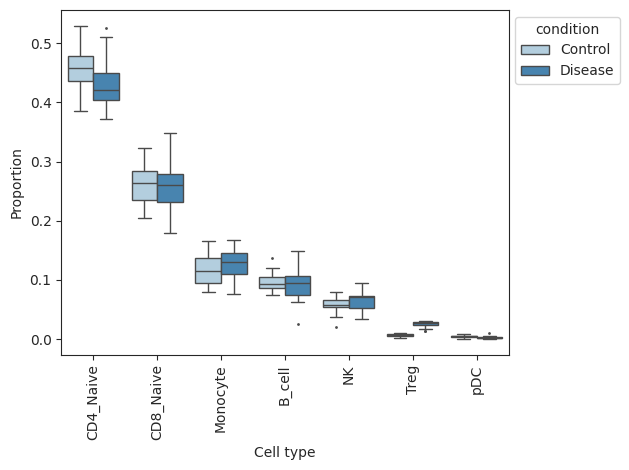

In [79]:
from sccoda.util import data_visualization as viz
viz.boxplots(adata_sccoda, feature_name="condition")